In [1]:
import os
import pandas as pd
import io
import matplotlib.pyplot as plt

start_date = pd.to_datetime('2023-05-01')

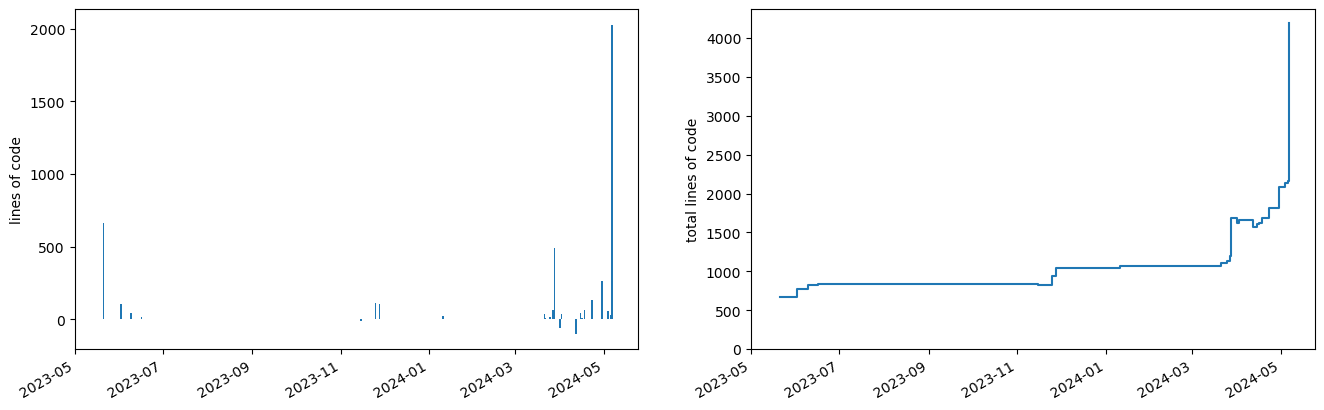

In [2]:
command = os.popen("echo 'date,lines,empty';/Users/stefan/bin/gitdatalines '*.tex'")

lines = pd.read_csv(io.StringIO(command.read()), sep=",")[['date', 'lines']]
lines["date"] = pd.to_datetime(lines["date"])
tlines = lines.groupby('date').sum()

fig, axs = plt.subplots(1,2, figsize=(16, 5))

axs[0].bar(tlines.index, tlines['lines'], width=1)
axs[0].set_xlabel("")
axs[0].set_ylabel("lines of code")

tlines.cumsum().plot(drawstyle="steps-post", legend=False, ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("total lines of code")
axs[1].set_ylim(0, None)

for ax in axs:
    ax.set_xlim(start_date, None)

fig.autofmt_xdate()
plt.show()

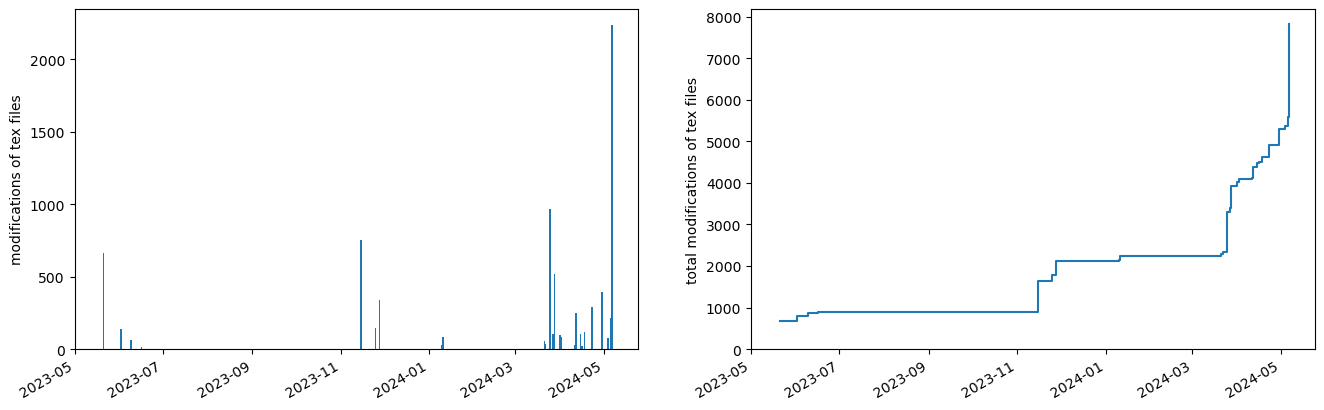

In [3]:
command = os.popen("echo 'date modifications';/Users/stefan/bin/gitdatamodifications '*.tex'")
modifications = pd.read_csv(io.StringIO(command.read()), sep=" ")[['date', 'modifications']]
modifications["date"] = pd.to_datetime(modifications["date"])
tmodifications = modifications.groupby('date').sum()

fig, axs = plt.subplots(1,2, figsize=(16,5))
axs[0].bar(tmodifications.index, tmodifications['modifications'], width=1)
axs[0].set_xlabel("")
axs[0].set_ylabel("modifications of tex files")

tmodifications.cumsum().plot(drawstyle="steps-post", legend=False, ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("total modifications of tex files")
axs[1].set_ylim(0, None)
for ax in axs:
    ax.set_xlim(start_date, None)
fig.autofmt_xdate()
plt.show()

/var/folders/9y/xdxkkt710kx5tf1j0p68y46r0000gn/T/ipykernel_41621/661420673.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  twdiffs = wdiffs.groupby('date').sum()


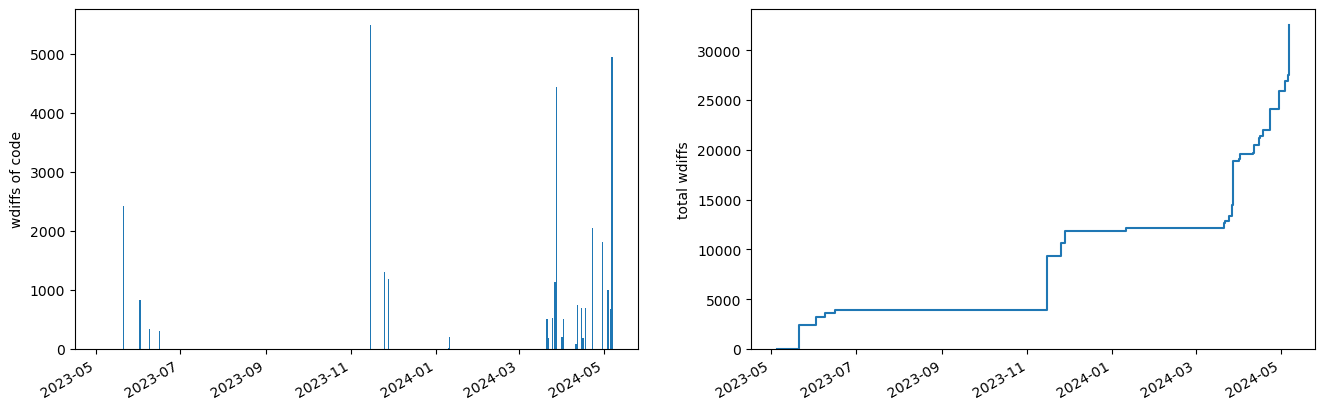

In [4]:
command = os.popen("/Users/stefan/bin/gitdataworddiffs")

wdiffs = pd.read_csv(io.StringIO(command.read()), sep=",")
wdiffs["date"] = pd.to_datetime(wdiffs["date"])
twdiffs = wdiffs.groupby('date').sum()

fig, axs = plt.subplots(1,2, figsize=(16, 5))

axs[0].bar(twdiffs.index, twdiffs['wdiffs'], width=1)
axs[0].set_xlabel("")
axs[0].set_ylabel("wdiffs of code")

twdiffs.cumsum().plot(drawstyle="steps-post", legend=False, ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("total wdiffs")
axs[1].set_ylim(0, None)

fig.autofmt_xdate()  
plt.show()

mktemp: unrecognized option `--suffix'
usage: mktemp [-d] [-p tmpdir] [-q] [-t prefix] [-u] template ...
       mktemp [-d] [-p tmpdir] [-q] [-u] -t prefix 
fatal: It seems that there is already a rebase-merge directory, and
I wonder if you are in the middle of another rebase.  If that is the
case, please try
	git rebase (--continue | --abort | --skip)
If that is not the case, please
	rm -fr "/Users/stefan/workspace/work/phd/thesis/.git/worktrees/thesis_progress/rebase-merge"
and run me again.  I am stopping in case you still have something
valuable there.

./progress.sh: line 20: $OUTFILE: ambiguous redirect
error: you need to resolve your current index first
./progress.sh: line 12: $OUTFILE: ambiguous redirect
error: you need to resolve your current index first
./progress.sh: line 12: $OUTFILE: ambiguous redirect
error: you need to resolve your current index first
./progress.sh: line 12: $OUTFILE: ambiguous redirect
error: you need to resolve your current index first
./progress.sh: l

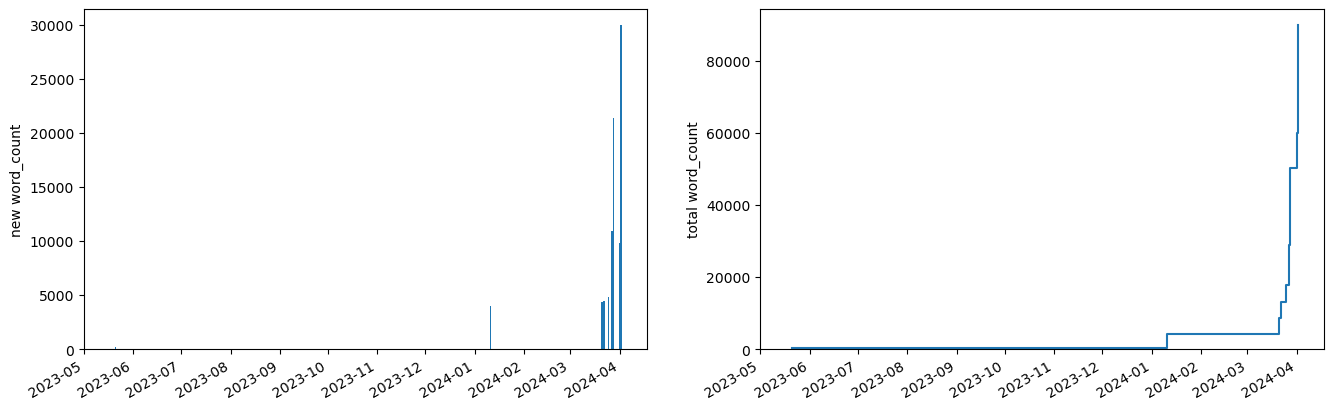

In [5]:
command = os.popen("cd ../thesis_progress && ./progress.sh")
_ = io.StringIO(command.read())

word_count = pd.read_csv("../thesis_progress/progress.csv")
word_count.dropna(inplace=True)

word_count["date"] = pd.to_datetime(word_count["date"])

tword_count = word_count.groupby('date').sum()

fig, axs = plt.subplots(1,2, figsize=(16, 5))

axs[0].bar(tword_count.index, tword_count['count'], width=1)
axs[0].set_xlabel("")
axs[0].set_ylabel("new word_count")

tword_count.cumsum().plot(drawstyle="steps-post", legend=False, ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("total word_count")
axs[1].set_ylim(0, None)

for ax in axs:
    ax.set_xlim(start_date, None)

fig.autofmt_xdate()
plt.show()